### Extended Data Figure 8

For EDFs 8c & 8e please see notebook for Figure 4

In [1]:
setwd(here::here())

library("metacell")
library("Matrix")
library("ggplot2")
library("ggrepel")
library("tgstat")
library("zoo")
library("qvalue")
library("devtools")
library("data.table")
library("tidyverse")
library("tglkmeans")
library('RColorBrewer')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: usethis

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.3     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.0     v forcats 1.0.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x purrr::transpose() masks data.table::transpose()
x tidyr::unpack()    masks Matrix::unpack()



In [2]:
source("scripts/manifold_2d_proj_hr.R")
scdb_init("scrna_db/", force_reinit=T)

fig_dir <- "figs/"
if(!dir.exists(fig_dir)) dir.create(fig_dir)
scfigs_init(fig_dir)

mat_exe <- scdb_mat("exe")
mc_exe <- scdb_mc("exe")
gset_exe = scdb_gset("exe")
mc2d_exe <- scdb_mc2d(id = "exe_umap")
md_exe <- mat_exe@cell_metadata[names(mc_exe@mc),]

mat_emb <- scdb_mat("emb")
mc_emb <- scdb_mc("emb")
gset_emb = scdb_gset("emb")
mc2d_emb <- scdb_mc2d(id = "emb_umap")
md_emb <- mat_emb@cell_metadata[names(mc_emb@mc),]

mat_embexe <- scdb_mat("embexe")
mc_embexe <- scdb_mc("embexe_recolored")
mc2d_embexe <- scdb_mc2d(id = "embexe_recolored_umap")
md_embexe <- mat_embexe@cell_metadata[names(mc_embexe@mc),]

initializing scdb to scrna_db/



In [3]:
scdb_init("scrna_db_mm10_star/", force_reinit=T)

mat_all = scdb_mat('embexe_bmp4_og2_stelzer_star')
mc_all <- scdb_mc("embexe_bmp4_og2_star")
md_all <- mat_all@cell_metadata[colnames(mat_all@mat),]

cmp_annot = readRDS('data/cmp_annot_embexe_bmp4.RData')
cmp_time = read.table("data/embexe_bmp4/time_match/time_match_summary.txt", header = T)
wt_age = read.table('data/embexe.transcriptional_rank_developmental_time_with_age_group.tsv',sep = '\t',h = T)

cmp_time = cmp_time  %>% left_join( wt_age %>% select(transcriptional_rank,developmental_time,age_group,morphological_stage) %>% rename(best_rank_query = transcriptional_rank))

included_colors = mc_embexe@color_key$color[c(1:38,43:50)]

initializing scdb to scrna_db_mm10_star/

Joining, by = "best_rank_query"


In [4]:
germline_ko_embryos = c("x4e26_Embryo_ExE_Bmp4_KO","x4e37_Embryo_ExE_Bmp4_KO",'x6e9_Embryo_ExE_Bmp4_KO',
                          "x4e34_Embryo_ExE_Bmp4_KO","x4e35_Embryo_ExE_Bmp4_KO")

germline_control_embryos = c('x4e19_Embryo_ExE_Bmp4_KO','x4e22_Embryo_ExE_Bmp4_KO',
                    'x4e31_Embryo_ExE_Bmp4_KO','x6e3_Embryo_ExE_Bmp4_KO',
                    'x6e2_Embryo_ExE_Bmp4_KO','x6e1_Embryo_ExE_Bmp4_KO',
                    'x6e6_Embryo_ExE_Bmp4_KO','x6e4_Embryo_ExE_Bmp4_KO')

In [5]:
col_to_ct =  mc_embexe@color_key$group
names(col_to_ct) = mc_embexe@color_key$color
ct_to_col = mc_embexe@color_key$color
names(ct_to_col) = mc_embexe@color_key$group

shades_rdbu <- rev(colorRampPalette(RColorBrewer::brewer.pal(11,name = "RdBu"))(100))
shades_blues <- colorRampPalette(RColorBrewer::brewer.pal(9,"Blues"))(100)
shades_reds <- colorRampPalette(RColorBrewer::brewer.pal(9,"Reds"))(100)
shades_yellows <- colorRampPalette(RColorBrewer::brewer.pal(9,"YlOrBr"))(100)
shades_greys <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greys"))(100)
shades_greens <- colorRampPalette(RColorBrewer::brewer.pal(9,"Greens"))(100)
shades_purples <- colorRampPalette(RColorBrewer::brewer.pal(9,"BuPu"))(100)

exe_project_cells = rownames(md_embexe)[(md_embexe[,"Experiment"] != "Wildtype project") & (md_embexe$embryo %in% wt_age$embryo)]

emb_age_df = unique(md_embexe[exe_project_cells,c("embryo","transcriptional_rank","developmental_time")])
emb_age_df = emb_age_df[order(emb_age_df$transcriptional_rank),]

sc_time_annot = data.frame("cell" = exe_project_cells, "embryo" = md_embexe[exe_project_cells,"embryo"])
sc_time_annot = left_join(sc_time_annot,emb_age_df,by = "embryo")
f = !is.na(sc_time_annot$developmental_time)
sc_time = sc_time_annot$developmental_time[f]
names(sc_time) = sc_time_annot$cell[f]

mc_time = tapply(sc_time,mc_embexe@mc[names(sc_time)],mean)

plot_size <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

In [16]:
chorion_mcs = which(mc_exe@colors == mc_exe@color_key$color[1])
chp_mcs = which(mc_exe@colors == mc_exe@color_key$color[2])
im_chor_mcs = which(mc_exe@colors == mc_exe@color_key$color[3])
spt_mcs = which(mc_exe@colors == mc_exe@color_key$color[4])
epc_mcs = which(mc_exe@colors == mc_exe@color_key$color[5])
tgc_mcs = which(mc_exe@colors == mc_exe@color_key$color[6])
ptgc_mcs = which(mc_exe@colors == mc_exe@color_key$color[7])
spa_mcs = which(mc_exe@colors == mc_exe@color_key$color[8])

## EDF 8d

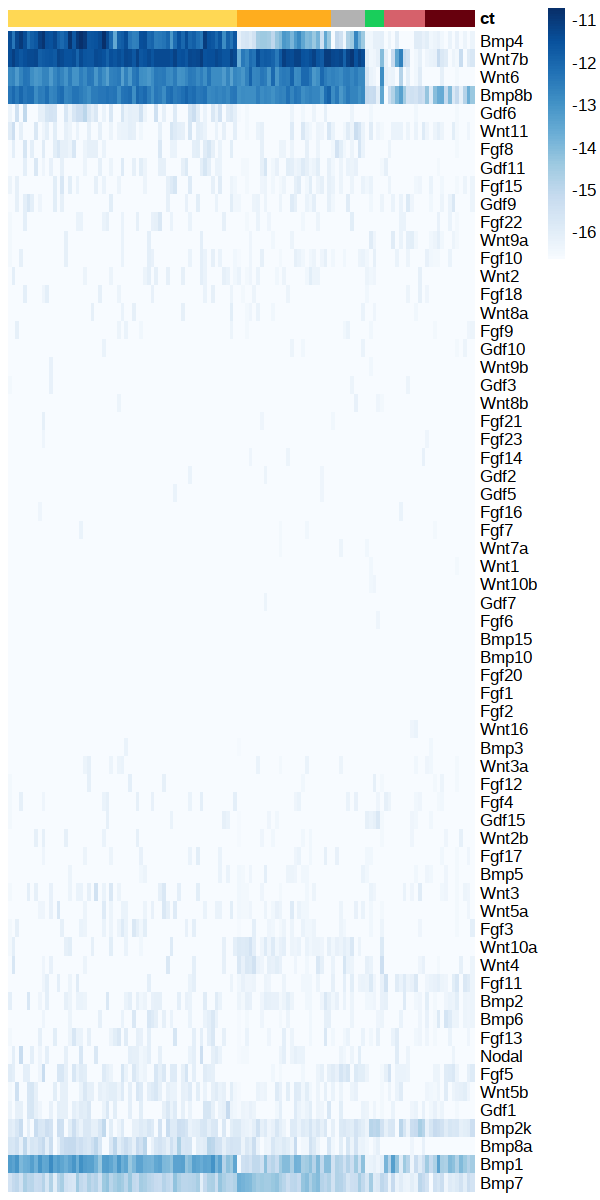

In [21]:
gns_to_plot <- c(grep("wnt[0-9]",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("fgf[0-9]",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("gdf[0-9]",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("bmp[0-9]",rownames(mat_all@mat),ignore.case = T,v=T),
                 "Nodal")

mcs_Chorion <- which(mc_exe@colors %in% c("#ffad1e","#ffd854","#b2b2b2"))
mcs_EPC <-  which(mc_exe@colors %in% c("#19ce5b","#d6616b","#67000d","#2e7ebc","#ff78fa"))
mcs_both <- c(chorion_mcs,tsc_mcs,tsc2_mcs,spt_mcs)

annotation_col = data.frame(ct = col_to_ct[mc_exe@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

egc = t(tgs_matrix_tapply(x = mat_exe@mat,
                     index = mc_exe@mc,
                     fun = sum))

egc = t(t(egc)/colSums(egc))

lfp <- log2(egc[gns_to_plot,c(chp_mcs,chorion_mcs,im_chor_mcs,spt_mcs,epc_mcs,tgc_mcs)] + 1e-5)

breaks = seq(log2(1e-5),-10, length.out = 101)
plot_size(5,10)
pheatmap::pheatmap(mat = lfp,treeheight_row = 0,
                               annotation_legend = F,
                            cluster_cols = F,
                            cluster_rows = T,
                            show_colnames = F,
                            show_rownames = T,
                            color = shades_blues,
                            annotation_col = annotation_col,
                            annotation_colors = annotation_colors,
                            border_color = NA)

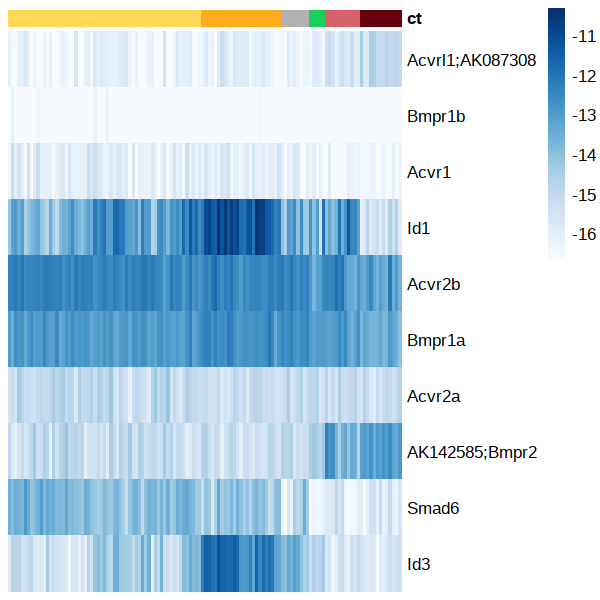

In [29]:
gns_to_plot <- c( grep("acvrl1",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("bmpr1b",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("Smad6",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("acvr2a",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("bmpr2",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("acvr2b",rownames(mat_all@mat),ignore.case = T,v=T),
                 grep("bmpr1a",rownames(mat_all@mat),ignore.case = T,v=T),
                 "Id1","Id3","Acvr1")

mcs_Chorion <- which(mc_exe@colors %in% c("#ffad1e","#ffd854","#b2b2b2"))
mcs_EPC <-  which(mc_exe@colors %in% c("#19ce5b","#d6616b","#67000d","#2e7ebc","#ff78fa"))
mcs_both <- c(chorion_mcs,tsc_mcs,tsc2_mcs,spt_mcs)

annotation_col = data.frame(ct = col_to_ct[mc_exe@colors],stringsAsFactors = F)
rownames(annotation_col) = c(1:nrow(annotation_col))
annotation_colors = list(ct = ct_to_col)

egc = t(tgs_matrix_tapply(x = mat_exe@mat,
                     index = mc_exe@mc,
                     fun = sum))

egc = t(t(egc)/colSums(egc))

lfp <- log2(egc[gns_to_plot,c(chp_mcs,chorion_mcs,im_chor_mcs,spt_mcs,epc_mcs,tgc_mcs)] + 1e-5)

breaks = seq(log2(1e-5),-10, length.out = 101)
plot_size(5,5)
pheatmap::pheatmap(mat = lfp,treeheight_row = 0,
                               annotation_legend = F,
                            cluster_cols = F,
                            cluster_rows = T,
                            show_colnames = F,
                            show_rownames = T,
                            color = shades_blues,
                            annotation_col = annotation_col,
                            annotation_colors = annotation_colors,
                            border_color = NA)